# Loading Data

# Imports

In [1]:
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
import pandas as pd
import os
import torch

from tqdm import tqdm
import pickle
from torch import nn
from torch.optim import Adam,RMSprop
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import math
from PIL import Image
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.metrics import roc_curve, auc
import random
from otsu import otsu


ModuleNotFoundError: No module named 'otsu'

# Creating Dataloader

In [2]:
#creating list of image pairs with combinations and labels of 1 or 0
path = r'dataset\dataset\train'
img_label_list = []

count = 0
authors = os.listdir(path)
for i,author_name in tqdm(enumerate(authors)):
  other_list = authors[i:i+2] if i<len(authors)-1 else authors[i:]
  for author_name2 in other_list:
    label = 1 if author_name == author_name2 else 0
    for img1 in os.listdir(os.path.join(path,author_name)):
      for img2 in os.listdir(os.path.join(path,author_name2)):
        if(author_name != author_name2 or img1 !=img2):

          
          img_label_list.append([os.path.join(path,author_name,img1),os.path.join(path,author_name2,img2),label])
         

0it [00:00, ?it/s]

1352it [00:08, 152.59it/s]


In [3]:
len(img_label_list)

183859

In [4]:
class SiameseDataset(Dataset):
  def __init__(self,array,path= None,transform = None):
    self.array =array
    self.transform = transform
    self.path = path
  def __getitem__(self,index):
    
    indexlist = self.array[index]
      
    if self.path is None:
      img0 = Image.open(indexlist[0])
      img1 = Image.open(indexlist[1])
    else:
      img0 = Image.open(os.path.join(self.path,indexlist[0]))
      img1 = Image.open(os.path.join(self.path,indexlist[1]))
    
    label = indexlist[2]
    img0 = img0.convert("L")
    img1 = img1.convert("L")
    
    threshold = 128
    bw_image0 = img0.point(lambda x: 0 if x < threshold else 1, "1")
    bw_image1 = img1.point(lambda x: 0 if x < threshold else 1, "1")
    
    if self.transform is not None:
      bw_image0 = self.transform(bw_image0)
      bw_image1 = self.transform(bw_image1)
    #converting grayscale to binary
    
    
    return bw_image0,bw_image1,label
  def __len__(self):
    return len(self.array)

In [5]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=0.05):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    


In [6]:
mytransform = transforms.Compose([transforms.Resize((250,25)),
                                  transforms.RandomRotation(22.5),
                                  
                                transforms.ToTensor(),
                                AddGaussianNoise()])

In [7]:
random.shuffle(img_label_list)
siamese_dataset = SiameseDataset(img_label_list,transform=mytransform)



In [15]:
train_dataloader = DataLoader(siamese_dataset,batch_size = 512)

In [11]:
train_dataloader1 = DataLoader(siamese_dataset,batch_size = 1)

In [9]:
df = pd.read_csv(r'D:\Shreyas\Shreyas_study\vision_Challenges\dataset\dataset\val.csv')
df

,img1_name,img2_name,label
0,70a4ba9a.jpg,58f68a00.jpg,1
1,e15b612e.jpg,16ce5df2.jpg,0
2,6c64d988.jpg,735d3636.jpg,1
3,b74681a6.jpg,cb50496d.jpg,0
4,c97aa428.jpg,6f9dc747.jpg,1
...,...,...,...
5765,4e7762f7.jpg,2f3d2bce.jpg,0
5766,c1c49f87.jpg,1072597f.jpg,0
5767,03e66099.jpg,f877b1b6.jpg,1
5768,8e056e51.jpg,f68e79a1.jpg,1


In [10]:
val_dataset = SiameseDataset(np.array(df),path = r'D:\Shreyas\Shreyas_study\vision_Challenges\dataset\dataset\val',transform=mytransform)

In [11]:
val_dataloader = DataLoader(val_dataset)

# Training the model

In [12]:
#create a siamese network
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        # Defining the fully connected layers
        self.cnn1 = nn.Sequential(
            nn.Conv2d(1, 1, kernel_size=3,stride=1),
            nn.MaxPool2d(3, stride=1),
            
           
            

           
        )



        # Defining the fully connected layers
        self.fc1 = nn.Sequential(
            
           
            
            nn.Linear(5166, 4096),
        
            nn.ReLU(inplace=True),
            
            nn.Linear(4096, 1024),
        
            nn.ReLU(inplace=True),
           
            nn.Linear(1024, 128),
            nn.ReLU(inplace=True),

            nn.Linear(128,2)
           
            )

            
        
        
    def forward_once(self, x):
        # Forward pass 
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

        
   

        

    def forward(self, input1, input2):
        # forward pass of input 1
        output1 = self.forward_once(input1)
        # forward pass of input 2
        output2 = self.forward_once(input2)
        return output1, output2


In [13]:
class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on:
    """

    def __init__(self, margin=1.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, x0, x1, y):
        # euclidian distance
        diff = x0 - x1
        dist_sq = torch.sum(torch.pow(diff, 2), 1)
        dist = torch.sqrt(dist_sq)
        
        mdist = self.margin - dist
        dist = torch.clamp(mdist, min=0.0)
        loss = y * dist_sq + (1 - y) * torch.pow(dist, 2) 
        
        loss = torch.sum(loss) / 2.0 / x0.size()[0]
        return loss

In [17]:
# Declare Siamese Network
n_epochs = 1
net = SiameseNetwork()#.cuda()
# Decalre Loss Function
criterion = ContrastiveLoss()
# Declare Optimizer
optimizer =RMSprop(net.parameters(), lr=1e-4, weight_decay=0.0005,momentum =0.9,eps = 1e-8)
#train the model
loss=[] 
counter=[]
test_loss = []
def train(epoch):
    net.train()
    tloss = 0
    for data in tqdm(train_dataloader):
        img0, img1 , label = data
            #img0, img1 , label = img0.cuda(), img1.cuda() , label.cuda()
        
        optimizer.zero_grad()
        output1,output2 = net(img0,img1)
        
        loss_contrastive = criterion(output1,output2,label)
        
        if(math.isnan(loss_contrastive.item())):
            print("Nan")
            break
        tloss+=(loss_contrastive.item())
        loss_contrastive.backward()
        optimizer.step()
        
        
        
    print("Epoch {}\n Current loss {}\n".format(epoch,tloss/1437))
    loss.append(tloss/1437)
def test(epoch):
    net.eval()
    with torch.no_grad():
        
        loss = 0
        for i in tqdm(val_dataloader):

            img0,img1,label = i
            #img0,img1 = img0.cuda(),img1.cuda()
            output1,output2 = net(img0,img1)
            sample_loss = criterion(output1,output2,label)
            loss+=sample_loss.item()
        
        test_loss.append(loss/5770)
        print("Epoch {}\n Current test loss {}\n".format(epoch,loss/5700))
    



        
#set the device to cuda

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
for i in range(1,n_epochs+1):
    train(i)
    test(i)
    counter.append(i)
plt.plot(range(n_epochs),loss,color = 'blue',label = 'Train Loss')
plt.plot(range(n_epochs),test_loss,color = 'red',label = 'Test Loss')
plt.legend()
plt.show()


  4%|▍         | 15/360 [03:14<1:14:27, 12.95s/it]


KeyboardInterrupt: 

REMBG !

# Testing

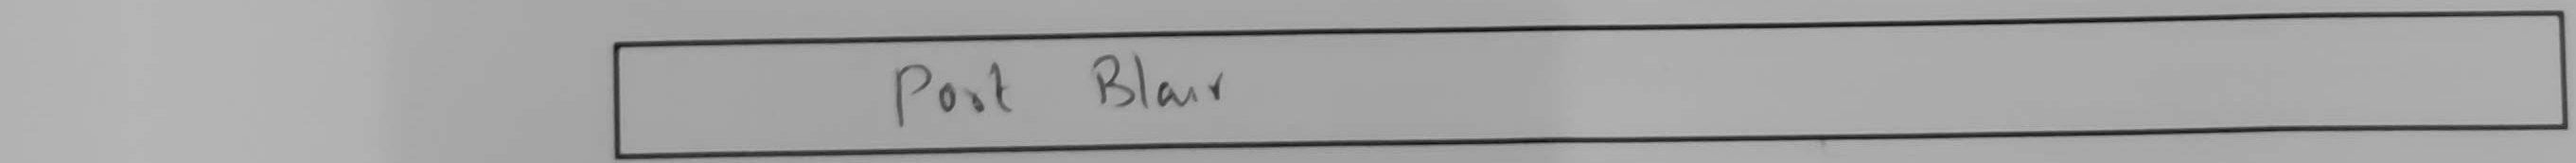

In [ ]:
img0 = Image.open(img_label_list[405][0])
img0

In [ ]:
img0.size

(2722, 172)

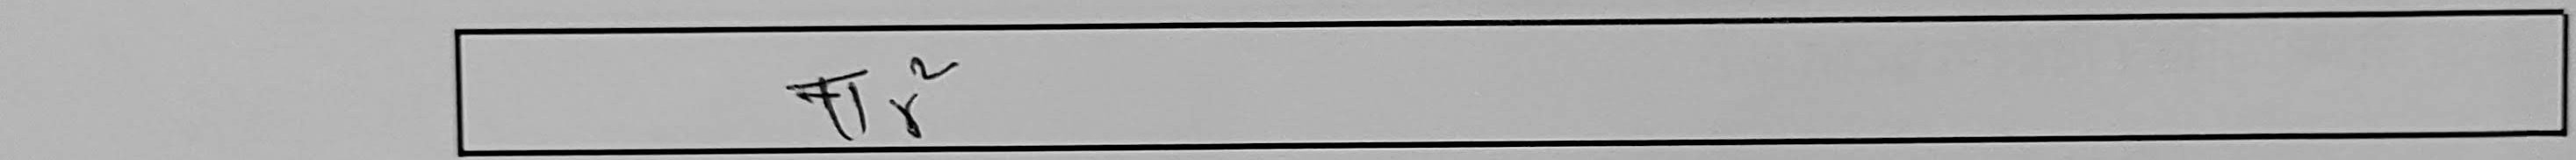

In [ ]:
img1 = Image.open(img_label_list[405][1])
img1

In [ ]:
label = img_label_list[405][2]
label

0

In [ ]:
img0.size

(2722, 172)

In [ ]:
img1.size

(2934, 182)

In [ ]:
net = SiameseNetwork()
net.load_state_dict(torch.load(r'D:\Shreyas\Shreyas_study\vision_Challenges\optim.pt'))

<All keys matched successfully>

In [ ]:
distances=np.zeros(183859)
net.eval()
with torch.no_grad():
  sumdist = 0
  counter = 0
  batch_size = 1

  for i in tqdm(train_dataloader1):
      
      img0,img1,label = i
      
      #img0,img1 = img0.cuda(),img1.cuda()
      
      output1,output2 = net(img0,img1)
      diff = output1 - output2
      dist_sq = torch.sum(torch.pow(diff, 2), 1)
      
      dist = torch.sqrt(dist_sq)
      
      # if(counter+batch_size-1<len(img_label_list)):
      #   distances[counter:counter+batch_size] = dist.cpu()
      #   counter+=batch_size
      # else:
      #   distances[counter:] = dist.cpu()
# for i in tqdm(enumerate(val_dataloader)):
#     img0,img1,_ = i
#     #img0,img1 = img0.cuda(),img1.cuda()
#     output1,output2 = model(img0,img1)
#     diff = output1 - output2
#     dist_sq = torch.sum(torch.pow(diff, 2), 1)
#     dist = torch.sqrt(dist_sq)
      

      
      


100%|██████████| 183859/183859 [59:01<00:00, 51.92it/s] 


In [ ]:
len(distances0)

94065

In [ ]:
min(distances0)

0.0

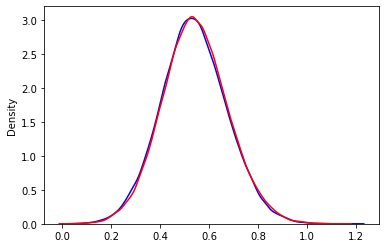

In [ ]:
import seaborn as sns
sns.kdeplot(distances1,color = 'blue')
sns.kdeplot(distances0,color= 'red')
plt.show()


In [ ]:
distances1.extend(distances0)


TypeError: object of type 'NoneType' has no len()

In [ ]:
distances = distances1
random.shuffle(distances)

94065

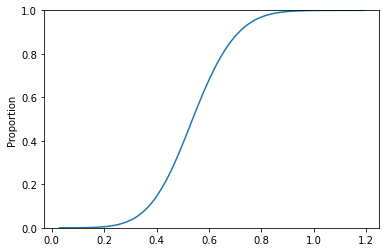

In [ ]:
_,probabilities = sns.ecdfplot(distances).get_lines()[0].get_data()

In [ ]:
def get_nearest_index(test_distance,array = sorted(distances)):
    array = np.asarray(array)
    
    return ((np.abs(array-test_distance)).argmin() if test_distance<max(array) else len(array)-1)

In [ ]:
def get_label_and_probability(test_distance,prob_array = probabilities[:-1]):
  idx = get_nearest_index(test_distance)
  prob = prob_array[idx]
  return (1,1-prob) if prob<0.5 else (0,1-prob)

In [ ]:
transform=transforms.Compose([transforms.Resize((250,25)),
                                                              transforms.ToTensor()
                                                                      ])

In [ ]:
val_dataset = SiameseDataset(np.array(df),path = r'D:\Shreyas\Shreyas_study\vision_Challenges\dataset\dataset\val',transform=mytransform)

In [ ]:
val_dataloader = DataLoader(val_dataset)

In [ ]:
with torch.no_grad():
  
  y_pred = np.zeros(5770)
  y_prob  = np.zeros(5770)

  for count,i in tqdm(enumerate(val_dataloader)):
    img0,img1,_ = i
    #img0,img1 = img0.cuda(),img1.cuda()
    output1,output2 = net(img0,img1)
    diff = output1 - output2
    dist_sq = torch.sum(torch.pow(diff, 2), 1)
    dist = torch.sqrt(dist_sq)
    
    (label,prob) = get_label_and_probability(dist.item())
    
    y_pred[count] = label
    y_prob[count] = prob
    

5770it [06:16, 15.31it/s]


In [ ]:
y_true = df['label'].values

In [ ]:
f1_score(y_true,y_pred)

0.5125348189415042

In [ ]:
roc_auc_score(y_true,y_prob)

0.5177352528617212

In [ ]:
df['label'] = y_pred
df['proba'] = y_prob

In [ ]:
df2 = pd.DataFrame()
df2['img1_name']  = df['img1_name']
df2['img2_name']  = df['img2_name']
df2['label'] = y_pred
df2['proba'] = y_prob

In [ ]:
df2

,img1_name,img2_name,label,proba
0,70a4ba9a.jpg,58f68a00.jpg,1.0,0.786837
1,e15b612e.jpg,16ce5df2.jpg,0.0,0.000044
2,6c64d988.jpg,735d3636.jpg,1.0,0.537205
3,b74681a6.jpg,cb50496d.jpg,0.0,0.000174
4,c97aa428.jpg,6f9dc747.jpg,0.0,0.116252
...,...,...,...,...
5765,4e7762f7.jpg,2f3d2bce.jpg,1.0,0.500144
5766,c1c49f87.jpg,1072597f.jpg,0.0,0.018819
5767,03e66099.jpg,f877b1b6.jpg,1.0,0.698329
5768,8e056e51.jpg,f68e79a1.jpg,1.0,0.891705


In [ ]:
df2.to_csv("Open CV_02.csv")

In [ ]:
threshold_dist = 9.2683e-06
with torch.no_grad():
  y_pred = np.zeros(5770)
  for count,i in tqdm(enumerate(val_dataloader)):
    path = '/content/dataset/val'
    img0,img1,label = i
    
    img0,img1 = img0.cuda(),img1.cuda()
    output1,output2 = net(img0,img1)
    diff = output1 - output2
    dist_sq = torch.sum(torch.pow(diff, 2), 1)
    dist = torch.sqrt(dist_sq)
    
    y_pred[count] = 1 if dist[0] <= threshold_dist else 0
    




0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)
5770it [01:26, 66.72it/s]


In [ ]:
y_true = df['label'].values

In [ ]:
f1_score(y_true, y_pred)

0.598336210955894

In [ ]:
roc_auc_score(y_true,y_prob)

0.5882648853058761

In [ ]:
for i in train_dataloader:
  img0,img1,label = i
  print(img0.size())
  break

torch.Size([128, 1, 250, 25])


In [ ]:
for i in img_label_list:
  img0,img1,label = i
  mlist= transform(Image.open(img0))
  mlist = mlist[None,:,:,:]
  print(mlist.size())
  break

torch.Size([1, 1, 250, 25])


In [ ]:
def train():
    